In [1]:
import warnings
import re
import json
from math import log, exp, sqrt, log10

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

import RNA

# Will require VARNAv3-93.jar to use the package
import varnaapi

In [2]:
FIG = 'Fig/'
rhoLst_default = np.logspace(-3,0.1, num=33)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
Temp_C = [t for t in range(-10, 110)]

In [3]:
# Some helpeer functions

def flattenLst(lstlst):
    return [t for lst in lstlst for t in lst]

def gc(seq):
    return (seq.count('C') + seq.count('G'))/len(seq)

def dimerECorrect(T = 37):
    return RNA.GASCONST*T*log(2)/1000

# Line charge density $\tau_{ss}$

In [4]:
from saltEnergy import bjerrumlength, BackboneLen, epsilonr

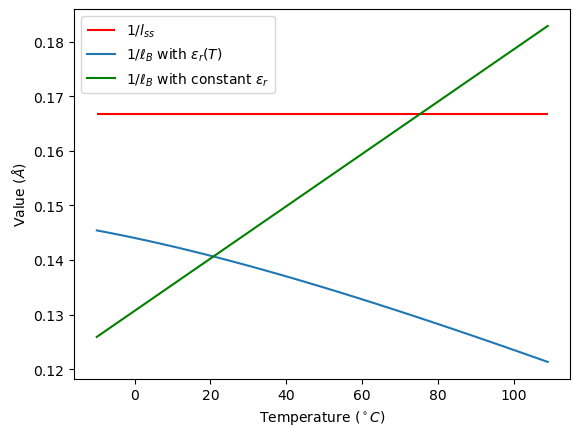

In [5]:
tlist = range(-10,110)

plt.hlines(1/BackboneLen, min(tlist), max(tlist), 'r', label=r'$1/l_{ss}$')
plt.plot(tlist, [1/bjerrumlength(t+RNA.K0) for t in tlist], label=r'$1/\ell_B$ with $\epsilon_r(T)$')
plt.plot(tlist, [1/bjerrumlength(t+RNA.K0,eps=False) for t in tlist], 'g', label=r'$1/\ell_B$ with constant $\epsilon_r$')
plt.legend()
plt.xlabel(r'Temperature ($^\circ C$)')
plt.ylabel(r'Value ($\AA$)')
plt.savefig(FIG+'tauss.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [6]:
for t in tlist:
    v = 1/BackboneLen - 1/bjerrumlength(t+RNA.K0, eps=False)
    if v < 0.001 and -0.001 < v:
        print(t, v)

74 0.00053439254721796
75 5.5832057172022775e-05
76 -0.0004227284328739145
77 -0.0009012889229198517


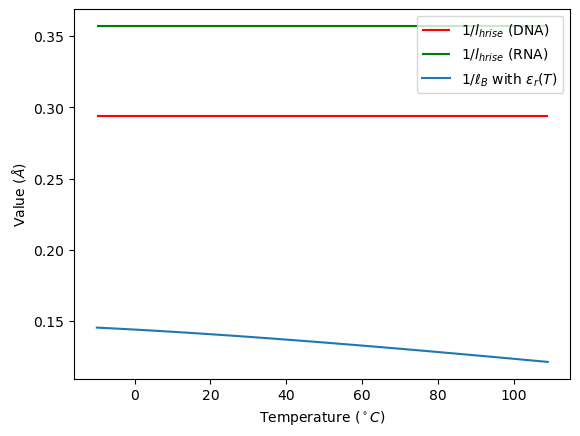

In [7]:
tlist = range(-10,110)

plt.hlines(1/3.4, min(tlist), max(tlist), 'r', label=r'$1/l_{hrise}$ (DNA)')
plt.hlines(1/2.8, min(tlist), max(tlist), 'g', label=r'$1/l_{hrise}$ (RNA)')
plt.plot(tlist, [1/bjerrumlength(t+RNA.K0) for t in tlist], label=r'$1/\ell_B$ with $\epsilon_r(T)$')
# plt.plot(tlist, [1/bjerrumlength(t+RNA.K0,eps=False) for t in tlist], 'g', label=r'$1/\ell_B$ with constant $\epsilon_r$')
plt.legend()
plt.xlabel(r'Temperature ($^\circ C$)')
plt.ylabel(r'Value ($\AA$)')
# plt.savefig(FIG+'tauss.pdf', bbox_inches='tight', dpi=200)
plt.show()

# Salt correction term

## Salt adjusted loop free energy

In [8]:
from saltEnergy import loopSaltEnergy

In [9]:
w = RNA.random_string(50, "ACGU")
saltP = r"SaltLoopDbl: \[(.*)\], SaltMLbase: ([-+]?\d+).*SaltMLclosing: ([-+]?\d+)"

In [10]:
rhos_loop = [1.021, 0.5, 0.1, 0.01]

loop_size = [i for i in range(1,31)]

In [11]:
py_loopcorr = []
vrna_loopcorr = []
fit_const = []

for rho in rhos_loop:
    md = RNA.md(salt=rho, saltMLLower=6, saltMLUpper=24)
    fc = RNA.fold_compound(w, md)
    tmp = str(fc.params)
    m = re.findall(saltP, tmp)
    vrna_loopcorr.append([float(t) for t in m[0][0].split(', ')])
    fit_const.append((int(m[0][1]), int(m[0][2])))
    py_loopcorr.append([loopSaltEnergy(m, rho) for m in loop_size])
print(fit_const)

[(0, 0), (0, 21), (0, 89), (14, 60)]


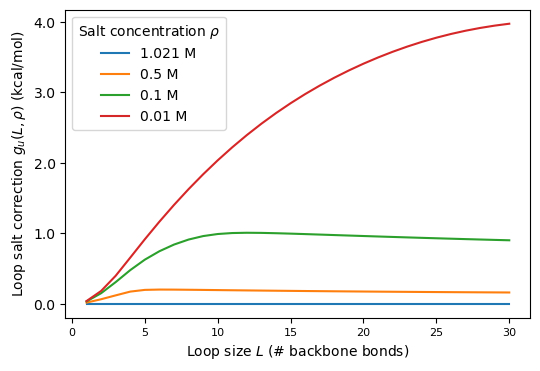

In [12]:
fig = plt.figure(figsize=(6, 4))
for i in range(len(rhos_loop)):
#     plt.plot(x, y[i], '-', color=colors[i], label='{} M'.format(rhos_loop[i]))
    plt.plot(loop_size, np.array(vrna_loopcorr[i][1:31])/100, color=colors[i], label='{} M'.format(rhos_loop[i]))
    
plt.legend(title=r'Salt concentration $\rho$')
plt.xlabel(r'Loop size $L$ (# backbone bonds)')
plt.xticks(fontsize=8)
# plt.xlim(1)
plt.ylabel(r'Loop salt correction $g_{u}(L, \rho)$ (kcal/mol)')
plt.yticks(ticks=[0,1,2,3,4], labels=[0.0, 1.0, 2.0, 3.0, 4.0])
# plt.title(r'Adjusted salt correction of a loop $\mathcal{G}^{salt}_{loop}$')
fig.savefig(FIG+'loop_salt_correction_adjusted.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [13]:
L = 10
correction_loop = []
for rho in rhos_loop:
    cor = [loopSaltEnergy(m=L, rho=rho, T=t+RNA.K0)/100 for t in Temp_C]
    correction_loop.append(cor)

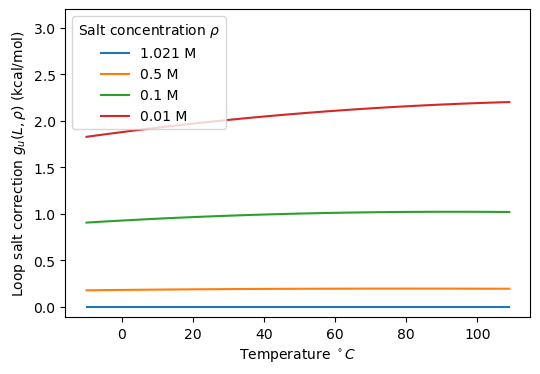

In [14]:
fig = plt.figure(figsize=(6, 4))
for ind, rho in enumerate(rhos_loop):
    plt.plot(Temp_C, correction_loop[ind], label='{} M'.format(rho), c=colors[ind])

plt.ylabel(r'Loop salt correction $g_{u}(L, \rho)$ (kcal/mol)')
plt.ylim(top=3.2)
pos, _ = plt.xticks()
# plt.xticks(pos[1:-1], [round(p-RNA.K0,2) for p in pos[1:-1]], fontsize=8)
plt.xlabel("Temperature $ ^\circ C$")
plt.legend(title=r'Salt concentration $\rho$')
fig.savefig(FIG+'loop_salt_correction_temp_all_L10.pdf', bbox_inches='tight', dpi=200)
plt.show()

### Linear function fitting for multi-loop

#### Distribution of multiloop size

In [15]:
def bracket_to_index(inst):
    """
    For a given bracket-dot presented secondary structure S, the function returns an iterger list L.
    L[i] = j if i and j are paired in S.
    Note: All unnested base pairs are ignored
    """
    res = [-1]*(len(inst)+2)
    tmp = []
    for i,c in enumerate("("+inst+")"):
        if c == '(':
            tmp.append(i)
        elif c == ')':
            j = tmp.pop()
            res[i], res[j] = j, i
    return res

def get_multi_size(inst):
    p = (inst[0][1], inst[0][0])
    new_inst = [p] + inst[1:] + [p]
    s = 0
    for i in range(len(new_inst)-1):
        s += new_inst[i+1][0] - new_inst[i][1]
    return s
        
def get_multi(inst):
    """
    Decompose a given bracket-dot presented RNA secondary structure into several basic components 
    in tree-presentation.
    A basic component is presented by a list of its paired bases positions
    """
    index = bracket_to_index(inst)
    def aux(ind):
        """
        A recursive function decomposing a given RNA secondary structure in index list 
        from a given starting position.
        """
        tmp = []
        res = []
        k = ind+1
        while True:
            if index[k] == -1 :
                k += 1
            elif index[k] > k:
                tmp.append((k, index[k]))
                res += aux(k)
                k = index[k]+1
            else:
                break
        return [[(ind,index[ind])]+tmp]+res

    res = [get_multi_size(t) for t in aux(0) if len(t) > 2 and t[0][0]!=0]
    return res

In [16]:
sizes = [50, 100, 200, 500, 1000]
multi_sizes = []
for size in sizes:
    print(size)
    tmp = []
    with open('ss/ss_{}_1021.txt'.format(size)) as f:
        for line in f.readlines():
            for l in get_multi(line.strip()):
                tmp.append(l)
    multi_sizes.append(tmp)

50
100
200
500
1000


In [17]:
size_lst = []
seq_size_lst = []
for ind, size in enumerate(sizes):
    for l in multi_sizes[ind]:
        size_lst.append(l)
        seq_size_lst.append(size)
size_df = pd.DataFrame({'Sequence length': seq_size_lst, 'ML size': size_lst})

In [18]:
# From RNAstrands
RNAstrands_ml_sizes = []
inSS = False
ss = ""
with open('download-dp-395.dp') as f:
    for line in f.readlines():
        line = line.strip()
        if inSS and line == "":
            inSS = False
            RNAstrands_ml_sizes += get_multi(ss)
            ss = ""
        elif line == "":
            continue
        elif inSS:
            ss += line
        elif line[0] in ['.', '(', ')', '[', ']', '{', '}']:
            inSS = True
            ss = line


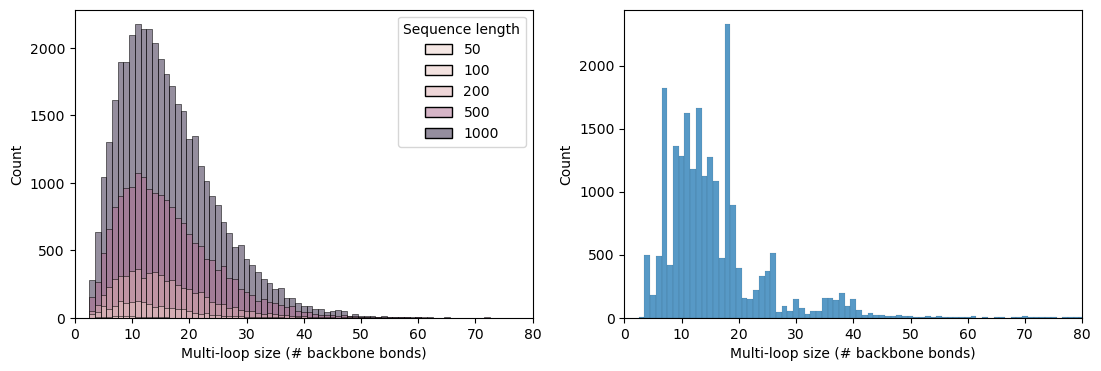

In [19]:
fig = plt.figure(figsize=(13, 4))
ax1 = plt.subplot(121)

sns.histplot(size_df, x='ML size', hue='Sequence length', discrete=True)
plt.xlim(0,80)
plt.xlabel('Multi-loop size (# backbone bonds)')


ax2 = plt.subplot(122)
sns.histplot(RNAstrands_ml_sizes, discrete=True)
plt.xlim(0, 80)
plt.xlabel('Multi-loop size (# backbone bonds)')


plt.savefig(FIG+'ML_size_dist.pdf', bbox_inches='tight', dpi=200)

#### Linear fit visualization

In [20]:
yfit = []
for m, c in fit_const:
    yfit.append([m*i+c for i in loop_size])

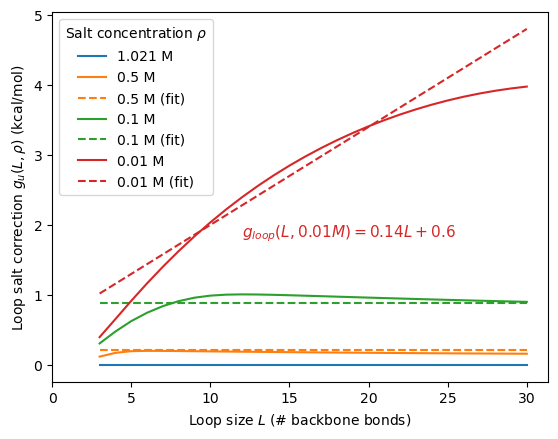

In [21]:
for i in range(len(rhos_loop)):
    plt.plot(loop_size[2:], np.array(py_loopcorr[i][2:])/100, '-', color=colors[i], label='{} M'.format(rhos_loop[i]))
    if rhos_loop[i] == 1.021:
        continue
    plt.plot(loop_size[2:], np.array(yfit[i][2:])/100, '--', color=colors[i], label='{} M (fit)'.format(rhos_loop[i]))
    
plt.legend(title=r'Salt concentration $\rho$')
plt.xlabel('Loop size $L$ (# backbone bonds)')
plt.ylabel(r'Loop salt correction $g_{u}(L, \rho)$ (kcal/mol)')
plt.xlim(0)
ind_todraw = 3
if (fit_const[ind_todraw][1] < 0):
    text = r'$g_{{loop}}(L, {rho} M) = {MLbase} L {MLclosing}$'
else:
    text = r'$g_{{loop}}(L, {rho} M) = {MLbase} L +{MLclosing}$'
plt.text(12, py_loopcorr[ind_todraw][8]/100, text.format(rho=rhos_loop[ind_todraw], MLbase=fit_const[ind_todraw][0]/100, MLclosing=fit_const[ind_todraw][1]/100), color=colors[ind_todraw], size=11)
# plt.title('Linear fitSalt correction for loop free enrgy')
plt.savefig(FIG+'loop_salt_correction_fit.pdf', bbox_inches='tight', dpi=200)
plt.show()

## Salt adjusted helix free energy

In [22]:
from saltEnergy import pairingSaltEnergy

Compairing stack correction term between soft constraint and integrated version

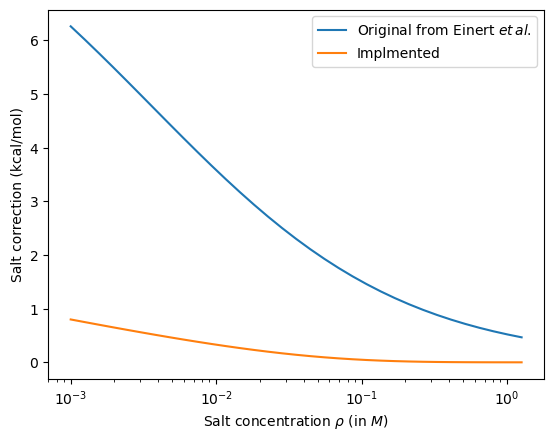

In [23]:
originSalt = [pairingSaltEnergy(rho, T=300, origin=True)/100 for rho in rhoLst_default]
corrected = [pairingSaltEnergy(rho, T=300)/100 for rho in rhoLst_default]
plt.plot(rhoLst_default, originSalt, label=r'Original from Einert $\it{et\, al.}$')
plt.plot(rhoLst_default, corrected, label='Implmented')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Salt concentration $\rho$ (in $M$)')
plt.ylabel('Salt correction (kcal/mol)')

plt.savefig(FIG+'stack_salt_correction.pdf', bbox_inches='tight', dpi=200)
plt.show()

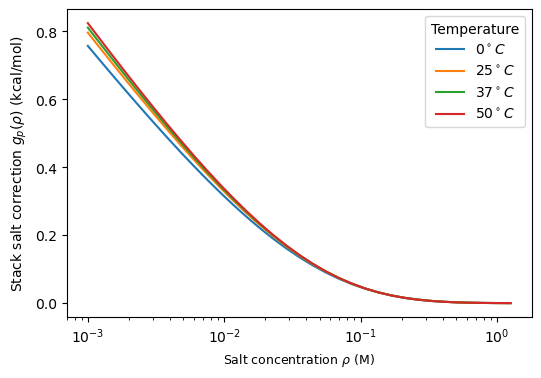

In [24]:
temp_list = [0, 25, 37, 50]
correction_stack = []
for t in temp_list:
    cor = [pairingSaltEnergy(rho, t+RNA.K0)/100 for rho in rhoLst_default]
    correction_stack.append(cor)

fig = plt.figure(figsize=(6, 4))
for ind, t in enumerate(temp_list):
    plt.plot(rhoLst_default, correction_stack[ind], label="{}$ ^\circ C$".format(t))

plt.ylabel(r'Stack salt correction $g_{p}(\rho)$ (kcal/mol)')
plt.xlabel(r"Salt concentration $\rho$ (M)", fontsize=9)
plt.xscale('log')
plt.legend(title='Temperature')
fig.savefig(FIG+'stack_salt_correction_rho_all.pdf', bbox_inches='tight', dpi=200)
plt.show()

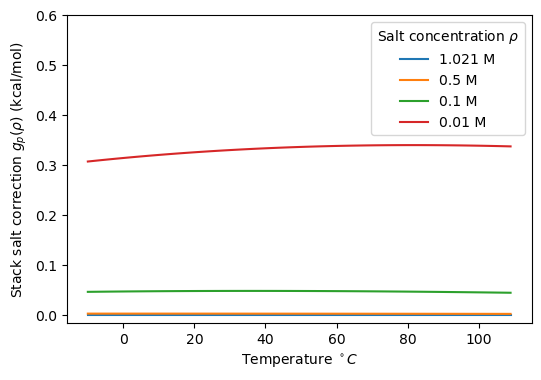

In [25]:
correction_stack = []
for rho in rhos_loop:
    cor = [pairingSaltEnergy(rho, t+RNA.K0)/100 for t in Temp_C]
    correction_stack.append(cor)
fig = plt.figure(figsize=(6, 4))
for ind, rho in enumerate(rhos_loop):
    plt.plot(Temp_C, correction_stack[ind], label="{} M".format(rho))

plt.ylabel(r'Stack salt correction $g_{p}(\rho)$ (kcal/mol)')
plt.ylim(top=0.6)
# pos, _ = plt.xticks()
# plt.xticks(pos[1:-1], [round(p-RNA.K0,2) for p in pos[1:-1]])
plt.xlabel("Temperature $ ^\circ C$")
plt.legend(title=r'Salt concentration $\rho$')
fig.savefig(FIG+'stack_salt_correction_temp_all.pdf', bbox_inches='tight', dpi=200)
plt.show()

### Mismatch

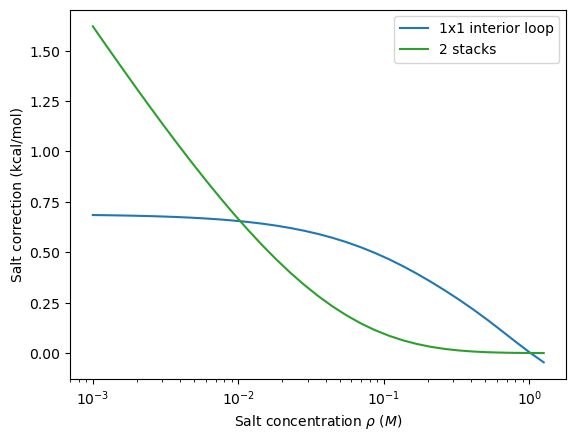

In [26]:
stackLst = [2*pairingSaltEnergy(k)/100 for k in rhoLst_default]
loopLst = [loopSaltEnergy(4, k)/100 for k in rhoLst_default]

plt.plot(rhoLst_default, loopLst, c=colors[0], label='1x1 interior loop')
plt.plot(rhoLst_default, stackLst, c=colors[2], label='2 stacks')

plt.xscale('log')
plt.xlabel(r'Salt concentration $\rho$ ($M$)')
plt.ylabel(r'Salt correction (kcal/mol)')
# plt.title(r'Value of $\kappa$ in the function of the salt concentration')
plt.legend()
plt.savefig(FIG+'mismatch_salt.pdf', bbox_inches='tight', dpi=200)
plt.show()

### Duplex formation cost fit

We use the data of 18 duplexes (Chen & Znosko, 2013) to learn the duplexe formation (intialization) energ cost in the function of salt concentration

In [27]:
# Energy of duplexes at different sodium concentration
rhoLstDuplexes = [0.071, 0.121, 0.221, 0.621, 1.021]
energyDuplexesExp = [[-8.12, -8.52, -8.87, -9.23, -9.12], 
                     [-8.76, -9.09, -9.40, -9.70, -9.90], 
                     [-10.23, -10.73, -10.90, -11.41, -11.69], 
                     [-8.85, -9.32, -9.83, -10.29, -10.56], 
                     [-6.85, -7.25, -7.67, -8.07, -8.51], 
                     [-6.32, -6.91, -7.38, -7.82, -7.99], 
                     [-5.10, -5.54, -5.94, -6.45, -6.59], 
                     [-5.37, -5.72, -6.18, -6.60, -6.68], 
                     [-5.44, -5.68, -6.34, -7.02, -7.30], 
                     [-6.22, -6.76, -7.18, -7.68, -7.80], 
                     [-5.69, -6.20, -6.53, -7.03, -7.11], 
                     [-5.96, -6.44, -6.77, -7.26, -7.35], 
                     [-6.24, -6.70, -7.13, -7.59, -7.98], 
                     [-5.81, -6.26, -6.69, -7.31, -7.38], 
                     [-5.09, -5.68, -6.24, -6.92, -7.16], 
                     [-4.86, -5.53, -6.04, -6.87, -6.98], 
                     [-4.37, -4.76, -5.46, -6.11, -6.16], 
                     [-4.45, -5.05, -5.82, -6.59, -6.58]]

In [28]:
# Compute the difference of experimental and predicted energy
# we assume this difference is due to the duplexe formation cost in different salt concentration
stack_correction = np.array([int(pairingSaltEnergy(rho, T=37+RNA.K0)) for rho in rhoLstDuplexes])
diff_to_exp_correction = np.array([[(v-lst[-1])*100 for v in lst] for lst in energyDuplexesExp])
for i in range(14):
    diff_to_exp_correction[i] = diff_to_exp_correction[i] - stack_correction*5
for i in range(14, 18):
    diff_to_exp_correction[i] = diff_to_exp_correction[i] - stack_correction*7

diff_to_exp_correction

array([[ 65.,  45.,  20., -11.,   0.],
       [ 79.,  66.,  45.,  20.,   0.],
       [111.,  81.,  74.,  28.,   0.],
       [136., 109.,  68.,  27.,   0.],
       [131., 111.,  79.,  44.,   0.],
       [132.,  93.,  56.,  17.,   0.],
       [114.,  90.,  60.,  14.,   0.],
       [ 96.,  81.,  45.,   8.,   0.],
       [151., 147.,  91.,  28.,   0.],
       [123.,  89.,  57.,  12.,   0.],
       [107.,  76.,  53.,   8.,   0.],
       [104.,  76.,  53.,   9.,   0.],
       [139., 113.,  80.,  39.,   0.],
       [122.,  97.,  64.,   7.,   0.],
       [158., 127.,  85.,  24.,   0.],
       [163., 124.,  87.,  11.,   0.],
       [130., 119.,  63.,   5.,   0.],
       [164., 132.,  69.,  -1.,   0.]])

In [29]:
# The one implemented in ViennaRNA
x = np.log(np.array(rhoLstDuplexes*18)/rhoLstDuplexes[-1])
y = np.array(flattenLst(diff_to_exp_correction))

def fit_func(x, a):
    return a*x

params = curve_fit(fit_func, x, y)
z = params[0]
print(z)

[-45.3244975]


In [30]:
p = np.poly1d([-45.324, 0])
duplexe_init = lambda rho: round(p(np.log(rho/1.021)))
print(p)

 
-45.32 x


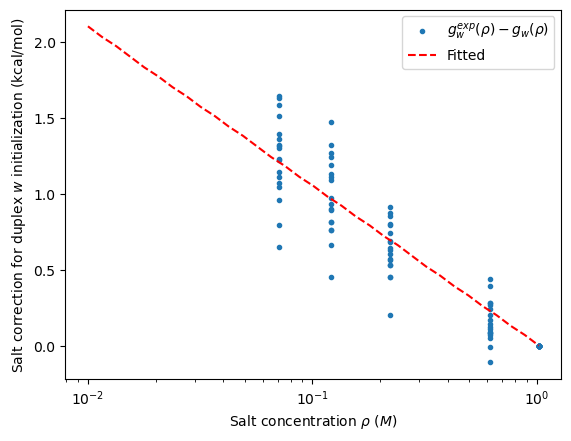

In [31]:
# Fir for 1.021M
rhoLst = np.logspace(-2,log10(1.021), num=33)

plt.plot([rho for rho in rhoLstDuplexes]*18, np.array(flattenLst(diff_to_exp_correction))/100, '.', label=r'$g_w^{exp}(\rho)-g_w(\rho)$')
plt.plot(rhoLst, [duplexe_init(rho)/100 for rho in rhoLst], '--', c='r', label='Fitted')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Salt concentration $\rho$ ($M$)')
plt.ylabel(r'Salt correction for duplex $w$ initialization (kcal/mol)')

plt.savefig(FIG+'duplex_salt_correction.pdf', bbox_inches='tight', dpi=200)
plt.show()

## Comparaison with Tan & Chen model

In [32]:
from saltEnergy import tan_chen_loop_correction_na, tan_chen_helix_correction_na

In [33]:
rhos_loop = [0.5, 0.1, 0.01, 0.001]

vrna_loop_size = [i for i in range(3,21)]

In [34]:
vrna_loopcorr = []
tan_chen_loopcorr = []

for rho in rhos_loop:
    vrna_loopcorr.append([loopSaltEnergy(m+1, rho) for m in vrna_loop_size])
    tan_chen_loopcorr.append([tan_chen_loop_correction_na(rho, m+2) for m in vrna_loop_size])

In [35]:
vrna_helix_size = [i for i in range(1,11)]
vrna_helixcorr = []
tan_chen_helixcorr = []
vrna_helixcorr_init = []

for rho in rhos_loop:
    vrna_helixcorr_init.append([pairingSaltEnergy(rho)*i + duplexe_init(rho) for i in vrna_helix_size])
    vrna_helixcorr.append([pairingSaltEnergy(rho)*i for i in vrna_helix_size])
    tan_chen_helixcorr.append([tan_chen_helix_correction_na(i+1, rho) for i in vrna_helix_size])

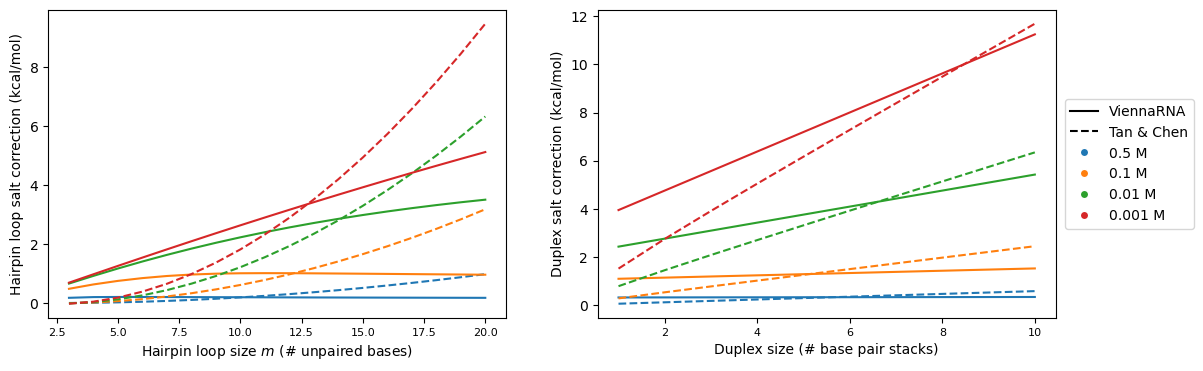

In [36]:
fig = plt.figure(figsize=(13, 4))
ax1 = plt.subplot(121)

for i in range(len(rhos_loop)):
#     plt.plot(x, y[i], '-', color=colors[i], label='{} M'.format(rhos_loop[i]))
    plt.plot(vrna_loop_size, np.array(vrna_loopcorr[i])/100, color=colors[i], label='{} M'.format(rhos_loop[i]))
    plt.plot(vrna_loop_size, np.array(tan_chen_loopcorr[i])/100, '--', color=colors[i], label='chen {} M'.format(rhos_loop[i]))
    
# plt.legend(title=r'Salt concentration $\rho$')
plt.xlabel(r'Hairpin loop size $m$ (# unpaired bases)')
plt.xticks(fontsize=8)
# plt.xlim(0)
plt.ylabel('Hairpin loop salt correction (kcal/mol)')
# legend_elements = [Line2D([], [], color='black', label='ViennaRNA'),
#                    Line2D([], [], ls='--', color='black', label='Tan & Chen')] + [Line2D([], [], marker='o', color='w', markerfacecolor=colors[i], label='{} M'.format(rho)) for i, rho in enumerate(rhos_loop)]
# plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)


ax2 = plt.subplot(122)

for i in range(len(rhos_loop)):
#     plt.plot(x, y[i], '-', color=colors[i], label='{} M'.format(rhos_loop[i]))
    plt.plot(vrna_helix_size, np.array(vrna_helixcorr_init[i])/100, color=colors[i], label='{} M'.format(rhos_loop[i]))
    plt.plot(vrna_helix_size, np.array(tan_chen_helixcorr[i])/100, '--', color=colors[i], label='chen {} M'.format(rhos_loop[i]))
    
# plt.legend(title=r'Salt concentration $\rho$')
plt.xlabel(r'Duplex size (# base pair stacks)')
plt.xticks(fontsize=8)
# plt.xlim(0)
plt.ylabel('Duplex salt correction (kcal/mol)')
legend_elements = [Line2D([], [], color='black', label='ViennaRNA'),
                   Line2D([], [], ls='--', color='black', label='Tan & Chen')] + [Line2D([], [], marker='o', color='w', markerfacecolor=colors[i], label='{} M'.format(rho)) for i, rho in enumerate(rhos_loop)]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)

fig.savefig(FIG+'compare_with_tan_chen.pdf', bbox_inches='tight', dpi=200)

plt.show()

# Data Validation

### List of experimental data

- Salt Dependence of Nucleic Acid Hairpin Stability (Williams & Hall, 1996)
    - RNA hairpin melting temperature in the function of concentration
- Eﬀect of Sodium Ions on RNA Duplex Stability (Chen & Znosko, 2013)
    - Free energy of 18 short RNA duplexes in the function of salt concentration
    - Same list for melting temperature
- Melting temperature of longer RNA duplexes (Nakano _et al_, 2007)

## RNA fold

In [37]:
def callMFE(w, rho, temp=None):
    """Returns minimum free energy of a given sequence and salt concentration
    
    Args:
        unit: options between "kCal" (default) and "kJ"
    """
    if temp is not None:
        md = RNA.md(salt=rho, temperature=temp)
    else:
        md = RNA.md(salt=rho)
    fc = RNA.fold_compound(w, md)
    ss, mfe = fc.mfe()
    return ss, mfe

### tRNA from origin paper

In [38]:
tRNA = "GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA"

In [39]:
def draw_tRNA(ss):
    v = varnaapi.Structure(structure=ss)
    v.set_bp_style('simple')
    v.update(baseNum='white')
    return v

0.001 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -1.8600000143051147
0.001 BP count: 20
['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                                                                            ', '-structureDBN', '..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))...............', '-o', 'Fig/trna_0.svg', '-baseNum', '#ffffff', '-bpStyle', 'simple']


Output file: Fig/trna_0.svg



['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                                                                            ', '-structureDBN', '..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))...............', '-o', 'Fig/trna_0.png', '-baseNum', '#ffffff', '-bpStyle', 'simple']


Output file: Fig/trna_0.png



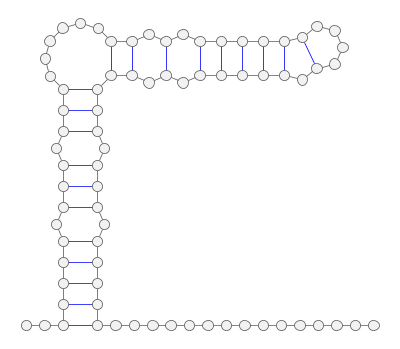

0.0010592537251772887 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -1.9900000095367432
0.001122018454301963 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -2.25
0.001188502227437019 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -2.380000114440918
0.0012589254117941675 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -2.509999990463257
0.001333521432163324 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -2.6500000953674316
0.001412537544622754 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -2.9100000858306885
0.0014962356560944327 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -3.0399999618530273
0.001584893192461114 M ..(((((.(((.(((......((.(.((((((....).))))).).))))).))).)))))............... -3.1700000762939453
0.0016788040181225606 M ..(((((.(((.(((......((.(.(((

Output file: Fig/trna_1.svg



['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                                                                            ', '-structureDBN', '.(((((((...((((((.((......)).)))))))))))))......(((((.......)))))...........', '-o', 'Fig/trna_1.png', '-baseNum', '#ffffff', '-bpStyle', 'simple']


Output file: Fig/trna_1.png



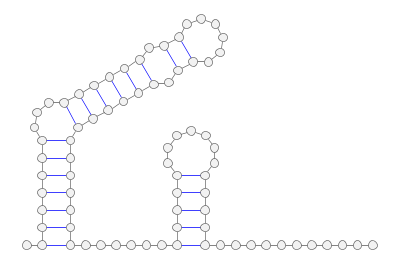

0.0026607250597988083 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -4.840000152587891
0.002818382931264455 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -5.010000228881836
0.0029853826189179603 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -5.179999828338623
0.0031622776601683794 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -5.340000152587891
0.003349654391578276 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -5.510000228881836
0.0035481338923357532 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -5.849999904632568
0.003758374042884443 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -6.019999980926514
0.003981071705534973 M .(((((((...((((((.((......)).)))))))))))))......(((((.......)))))........... -6.190000057220459
0.004216965034285823 M .(((((((...((((((.((.

Output file: Fig/trna_2.svg



['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                                                                            ', '-structureDBN', '(((((((..((((........)))).(((((.......))))).....(((((.......))))))))))))....', '-o', 'Fig/trna_2.png', '-baseNum', '#ffffff', '-bpStyle', 'simple']


Output file: Fig/trna_2.png



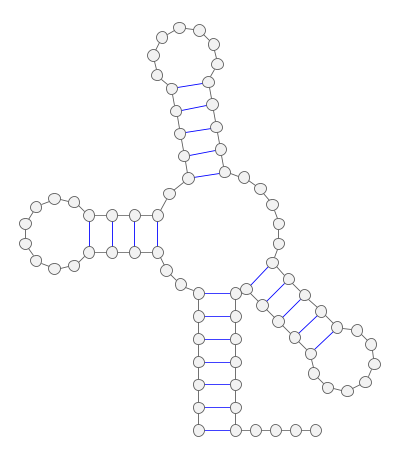

0.011885022274370183 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -9.9399995803833
0.012589254117941675 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -10.260000228881836
0.01333521432163324 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -10.460000038146973
0.014125375446227547 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -10.640000343322754
0.014962356560944336 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -10.949999809265137
0.01584893192461114 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -11.140000343322754
0.016788040181225608 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -11.3100004196167
0.01778279410038923 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -11.489999771118164
0.01883649089489801 M (((((((..((((........)))).

0.6 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -21.829999923706055
0.7 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.010000228881836
0.8 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.15999984741211
0.9 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.280000686645508
1.0 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.389999389648438
1.1 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.479999542236328
1.2 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.549999237060547
1.3 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.610000610351562
1.4 M (((((((..((((........)))).(((((.......))))).....(((((.......)))))))))))).... -22.670000076293945
1.5 M (((((((..((((........)))).(((((.......))))).....(((((.......))))))))

Output file: Fig/trna_3.svg



['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                                                                            ', '-structureDBN', '(((((((....((((((.((......)).)))))).((((....))))(((((.......))))))))))))....', '-o', 'Fig/trna_3.png', '-baseNum', '#ffffff', '-bpStyle', 'simple']


Output file: Fig/trna_3.png



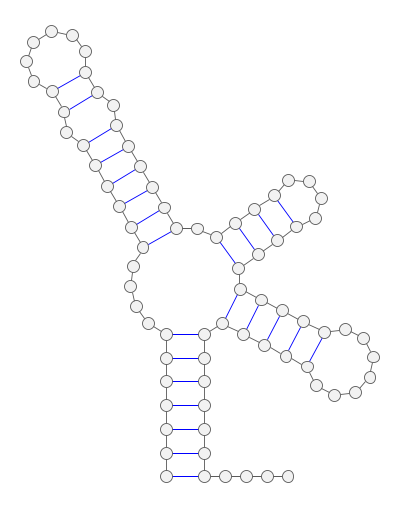

6.7 M (((((((....((((((.((......)).)))))).((((....))))(((((.......)))))))))))).... -23.469999313354492
6.8 M (((((((....((((((.((......)).)))))).((((....))))(((((.......)))))))))))).... -23.479999542236328
6.9 M (((((((....((((((.((......)).)))))).((((....))))(((((.......)))))))))))).... -23.479999542236328
7.0 M (((((((....((((((.((......)).)))))).((((....))))(((((.......)))))))))))).... -23.489999771118164


In [40]:
y = []
c = ""
counter = 0
rhoLst_tRNA = list(np.logspace(-3,0, num=121)) + [t/10 for t in range(1,71)]

for rho in rhoLst_tRNA:
    ss, mfe = callMFE(tRNA, rho)
    y.append(ss.count('('))
    print(rho, 'M', ss, mfe)
    if not ss == c:
        print(rho, "BP count:", ss.count('('))
        c = ss
        v = draw_tRNA(c)
        v.savefig(FIG+'trna_{}.svg'.format(counter))
        v.savefig(FIG+'trna_{}.png'.format(counter), show=True)
        counter+=1

### Structural motifs count

In [41]:
structural_df = pd.read_csv('ss_count_detail.csv')

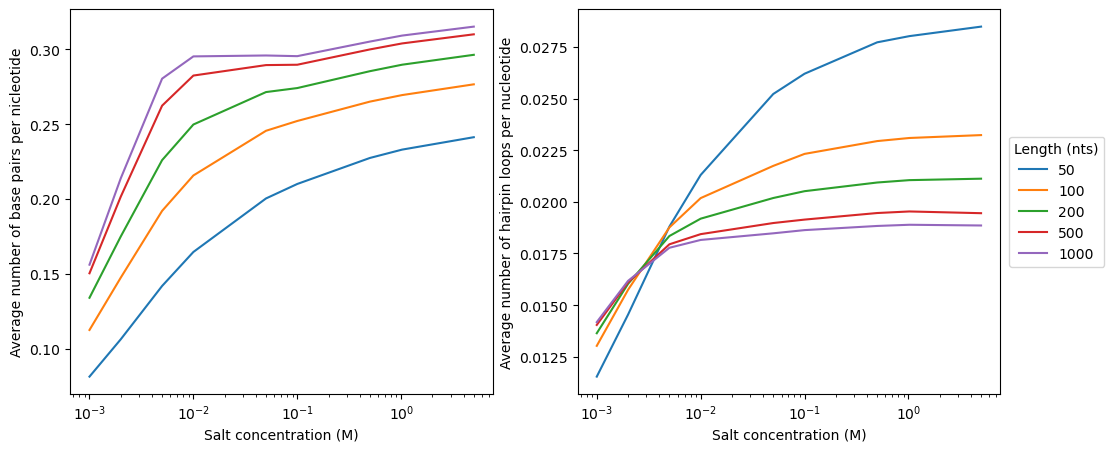

In [42]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)


for ind, size in enumerate([50, 100, 200, 500, 1000]):
    df_tmp = structural_df[structural_df['Size'] == size]
    plt.plot(list(df_tmp['Salt']), list(df_tmp['# base pair']/size), label=size)
plt.xscale('log')
plt.xlabel('Salt concentration (M)')
plt.ylabel('Average number of base pairs per nicleotide')

ax2 = plt.subplot(122)

for size in [50, 100, 200, 500,1000]:
    df_tmp = structural_df[structural_df['Size'] == size]
    plt.plot(list(df_tmp['Salt']), list(df_tmp['# hairpin']/size), label=size)
plt.legend(title='Length (nts)', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)

plt.xscale('log')
plt.xlabel('Salt concentration (M)')
plt.ylabel('Average number of hairpin loops per nucleotide')
plt.savefig(FIG+'/structural_count.pdf', bbox_inches='tight', dpi=200)

plt.show()

### Hairpin squences (L10,L8) from Williams & Hall, 1996

In [43]:
L10 = 'GAAGCCAUUGCACUCCGGCUUC'
L8 = 'GAAGCCAUUGCACCGGCUUC'

HP_rho_list = [0.021, 0.036, 0.061, 0.111, 0.211, 1.011]
HP_rho_list_0 = [0.01, 0.025, 0.05, 0.1, 0.2, 1]

Experimental data

In [44]:
# L10
L10_exp_H = np.array([61.1, 58.9, 62.5, 63.8, 62.3, 67.4])
L10_exp_S = np.array([182.1, 174.1, 182.4, 184.3, 178.1, 189.5])
# L8
L8_exp_H = np.array([62.9, 69.8, 60.4, 66.8, 66.3, 62.0])
L8_exp_S = np.array([185, 203.5, 174.5, 191.5, 188.5, 173.1])

def L10_exp(T):
    return  - L10_exp_H + L10_exp_S*(RNA.K0+T)/1000

def L8_exp(T):
    return  - L8_exp_H + L8_exp_S*(RNA.K0+T)/1000

L10_exp_37 = L10_exp(37)
L8_exp_37 = L8_exp(37)

print(L10_exp_37)
print(L8_exp_37)

[-4.621685 -4.902885 -5.92864  -6.639355 -7.062285 -8.626575]
[-5.52225  -6.684475 -6.278825 -7.406275 -7.836725 -8.313035]


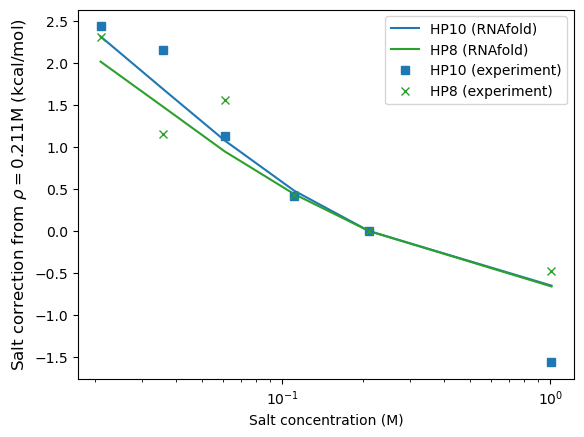

In [45]:
RNA.params_load_RNA_Turner2004()
energy1 = [callMFE(L10, rho, temp=37)[1] for rho in HP_rho_list]
energy2 = [callMFE(L8, rho, temp=37)[1] for rho in HP_rho_list]

plt.plot(HP_rho_list, [t-energy1[-2] for t in energy1], c=colors[0], label='HP10 (RNAfold)')
plt.plot(HP_rho_list, [t-energy2[-2] for t in energy2], c=colors[2], label='HP8 (RNAfold)')
plt.plot(HP_rho_list, [t-L10_exp_37[-2] for t in L10_exp_37], 's', c=colors[0], label='HP10 (experiment)')
plt.plot(HP_rho_list, [t-L8_exp_37[-2] for t in L8_exp_37], 'x', c=colors[2], label='HP8 (experiment)')

    
plt.xscale('log')
plt.legend()
plt.ylabel(r'Salt correction from $\rho={}$M (kcal/mol)'.format(HP_rho_list[-2]), size=12)
plt.xlabel('Salt concentration (M)')

plt.savefig(FIG+'/HP_salt_energy_corr.pdf', bbox_inches='tight', dpi=200)
plt.show()

### Hairpin salt correction from Groebe & Uhlenbeck, 1988

In [46]:
# Structural representation of 14 hairpin (#stack, has HP, has bulge)
# All haipins have the same representation except the #13
Groebe_std = list(range(12))+[13]
GroebeHP = (6,1,1)
GroebeHP_13 = (7,1,0)

In [47]:
# From table 1
Groebe1M = np.array([-7.7,-8.1,-7.4,-7.3,-6.7,-6.0,-5.0,-9.3,-7.7,-7.6,-7.6,-8.4,-11.1,-7.0])
# From table 5
# the real concentration should be 0.03M since there's 0.01mM of disodium phosephate in the solution
Groebe10mM = np.array([-4.1,-4.3,-3.5,-4.3,-2.6,-2.2,-1.1,-5.2,-4.3,-4.2,-4.0,-4.6,-8.2,-3.6])

GroebeCor_exp = Groebe10mM - Groebe1M
GroebeCor_exp

array([3.6, 3.8, 3.9, 3. , 4.1, 3.8, 3.9, 4.1, 3.4, 3.4, 3.6, 3.8, 2.9,
       3.4])

In [48]:
print(np.mean(GroebeCor_exp[Groebe_std]))
print(np.std(GroebeCor_exp[Groebe_std]))

3.676923076923077
0.30421107589669527


In [49]:
stackcor = (int(pairingSaltEnergy(0.03))-int(pairingSaltEnergy(1.02)))/100
hploopcor = (int(loopSaltEnergy(5, 0.03))- int(loopSaltEnergy(5, 1.02)))/100
bulgecor = (int(loopSaltEnergy(3, 0.03))-int(loopSaltEnergy(3, 1.02)))/100

print(stackcor, hploopcor, bulgecor)

def groebe_vrna(hp):
    return stackcor*hp[0] + hploopcor*hp[1] + bulgecor*hp[2]

0.16 0.82 0.37


In [50]:
print(groebe_vrna(GroebeHP))
print(groebe_vrna(GroebeHP_13))

2.15
1.94


### RNA duplexes from Chen & Znosko, 2013

#### Helper functions

In [51]:
duplexes = ["CGCGCG", "CGGCCG", "GCCGGC", "GCGCGC", "ACCGGU", "AGCGCU", "CACGUG", "CAGCUG", "CCAUGG", "CCUAGG", "CUGCAG", "GACGUC", "GAGCUC", "GCAUGC", "AACUAGUU", "ACUAUAGU", "ACUUAAGU", "AGAUAUCU"]
rhoLstDuplexes = [0.071, 0.121, 0.221, 0.621, 1.021]
rhoLstDuplexes_0 = [0.05, 0.1, 0.2, 0.6, 1]


def getStackCor(T, salt):
    w = RNA.random_string(10, "ACGU")
    md = RNA.md(temperature=T, salt=salt)
    return int(re.findall(r"SaltStack: ([-+]?\d+)", str(RNA.fold_compound(w, md).params))[0])/100

In [52]:
def energyCorrection(rho1, rho2, energy1, fgc):
    return energy1 + (0.324*fgc-0.468)*log(rho2/rho1) + 0.133*(log(rho2)*log(rho2)-log(rho1)*log(rho1))

class EnergyCorrect:
    def __init__(self, label, param, call):
        self.label = label
        self.param = param
        self.call = call
    def name(self):
        return "{} {}={{}}".format(self.label, self.param)
    def __call__(self, *data):
        return self.call(*data)

In [53]:
QuadraticCorrect = EnergyCorrect("Chen & Znosko", "fgc", lambda rho1, rho2, fgc: (0.324*fgc-0.468)*log(rho2/rho1) + 0.133*(log(rho2)*log(rho2)-log(rho1)*log(rho1)))
RNAfoldCorrect = EnergyCorrect("RNAcofold w/o Init", "len", lambda rho1, rho2, nb: nb*getStackCor(37, rho2))
RNAfoldInitCorrect = EnergyCorrect("RNAcofold w/ Init", "len", lambda rho1, rho2, nb: nb*getStackCor(37, rho2)+round(duplexe_init(rho2))/100)

EnergyCorrectLst = [RNAfoldCorrect, RNAfoldInitCorrect, QuadraticCorrect]

Energy correction at different salt concentration from $1M$.

In [54]:
energyDuplexesExp = [[-8.12, -8.52, -8.87, -9.23, -9.12], 
                     [-8.76, -9.09, -9.40, -9.70, -9.90], 
                     [-10.23, -10.73, -10.90, -11.41, -11.69], 
                     [-8.85, -9.32, -9.83, -10.29, -10.56], 
                     [-6.85, -7.25, -7.67, -8.07, -8.51], 
                     [-6.32, -6.91, -7.38, -7.82, -7.99], 
                     [-5.10, -5.54, -5.94, -6.45, -6.59], 
                     [-5.37, -5.72, -6.18, -6.60, -6.68], 
                     [-5.44, -5.68, -6.34, -7.02, -7.30], 
                     [-6.22, -6.76, -7.18, -7.68, -7.80], 
                     [-5.69, -6.20, -6.53, -7.03, -7.11], 
                     [-5.96, -6.44, -6.77, -7.26, -7.35], 
                     [-6.24, -6.70, -7.13, -7.59, -7.98], 
                     [-5.81, -6.26, -6.69, -7.31, -7.38], 
                     [-5.09, -5.68, -6.24, -6.92, -7.16], 
                     [-4.86, -5.53, -6.04, -6.87, -6.98], 
                     [-4.37, -4.76, -5.46, -6.11, -6.16], 
                     [-4.45, -5.05, -5.82, -6.59, -6.58]]
len(energyDuplexesExp)

18

#### Energy Correction (from standard concentration) plot

In [55]:
def correction_plot(indx, fgc, l):
    rhoLst = np.logspace(-3,log10(1.021), num=33)

    data = flattenLst([[v - energyDuplexesExp[ind][-1] for v in energyDuplexesExp[ind]] for ind in indx])
    x = rhoLstDuplexes*len(indx)
    plt.plot(x, data, 'x', label='Experiment')

    for correct in EnergyCorrectLst:
        if correct.param == 'fgc':
            param = fgc
        elif correct.param == 'len':
            param = l
#         elif correct.param == 'seq':
#             param = w
        plt.plot(rhoLst, [correct(1.021, rho, param) for rho in rhoLst], label=correct.label)
        
    plt.title("GC={}, length={}".format(fgc,l+1), fontsize=8)
#     plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
    plt.xscale('log')
    plt.xlabel(r'Salt concentration $\rho$ (M)')


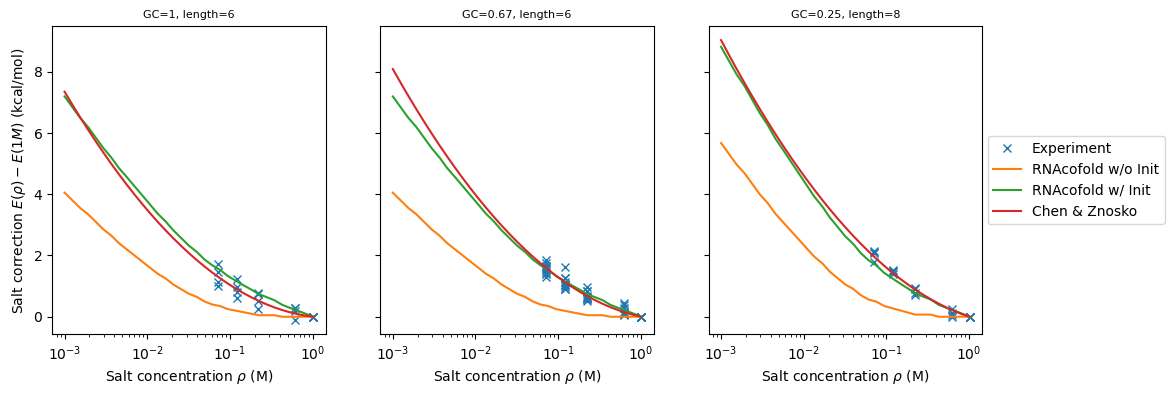

In [56]:
EnergyCorrectLst = [RNAfoldCorrect, RNAfoldInitCorrect, QuadraticCorrect]

plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
correction_plot([0,1,2,3], 1, 5)
plt.ylabel(r'Salt correction $E(\rho) - E(1M)$ (kcal/mol)')
# plt.ylabel(r'Salt correction $\Delta G(\rho) - \Delta G(1M)$ (kcal/mol)')
ax2 = plt.subplot(132, sharey=ax1)
correction_plot(range(4,14), 0.67, 5)
plt.tick_params('y', labelleft=False)
ax3 = plt.subplot(133, sharey=ax1)
correction_plot(range(14,18), 0.25, 7)
plt.tick_params('y', labelleft=False)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)

plt.savefig(FIG+'salt_correction_chen.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [57]:
def correction_mse(indx, fgc, l):
    print("GC={}, length={}".format(fgc,l+1))
    data = np.array(flattenLst([[v - energyDuplexesExp[ind][-1] for v in energyDuplexesExp[ind]] for ind in indx]))
    x = rhoLstDuplexes*len(indx)

    for correct in [RNAfoldInitCorrect, QuadraticCorrect]:
        if correct.param == 'fgc':
            param = fgc
        elif correct.param == 'len':
            param = l
        predict = np.array([correct(1.021, rho, param) for rho in x])
        print(correct.label+':', (np.square(predict - data)).mean())



In [58]:
correction_mse([0,1,2,3], 1, 5)
correction_mse(range(4,14), 0.67, 5)
correction_mse(range(14,18), 0.25, 7)

GC=1, length=6
RNAcofold w/ Init: 0.07234500000000006
Chen & Znosko: 0.041394769612625885
GC=0.67, length=6
RNAcofold w/ Init: 0.02224400000000001
Chen & Znosko: 0.021242059571722743
GC=0.25, length=8
RNAcofold w/ Init: 0.04331000000000004
Chen & Znosko: 0.013388058100782311


## Melting Temperature (RNA heat)

### RNA duplexes from Chen & Znosko, 2013

In [59]:
duplexes = ["CGCGCG", "CGGCCG", "GCCGGC", "GCGCGC", "ACCGGU", "AGCGCU", "CACGUG", "CAGCUG", "CCAUGG", "CCUAGG", "CUGCAG", "GACGUC", "GAGCUC", "GCAUGC", "AACUAGUU", "ACUAUAGU", "ACUUAAGU", "AGAUAUCU"]
rhoLstDuplexes = [0.071, 0.121, 0.221, 0.621, 1.021]

In [60]:
R = RNA.GASCONST / 1000

def tm(FAA, FA, ct):
    return (-FAA+2*FA)/(-R*log(ct))

def duplex_sym_Tm(w, rho, ct, T, init=99999):
    md = RNA.md(salt=rho, temperature=T, saltDPXInit=init)
    md.uniq_ML = 1
    fc = RNA.fold_compound('{seq}&{seq}'.format(seq=w), md)
    _, FA, FB, FcAB, FAB = fc.pf_dimer()
    return tm(FcAB, FA, ct)

def get_Tm(w, rho, ct, init=99999):
    curlower = 0
    curupper = 100
    current_T = 0
    expTm = 0
    while (not abs(curupper-curlower) < 0.05):
        current_T = round((curlower+curupper)/2, 5)
        expTm = round(duplex_sym_Tm(w, rho, ct, current_T, init=init)-RNA.K0, 5)

        if abs(current_T-expTm) < 0.05:
            break
               
        if current_T > expTm:
            curupper = current_T
        else:
            curlower = current_T           
    return current_T

#### InvTm v.s. log Ct

In [61]:
data = json.load(open('Data/Chen_Znosko/data.json'))

In [62]:
postData = []
for ind, inst in enumerate(data):
    w = inst['seq1']
    rho = inst['na_concentration']/1000
    species = inst['rna_concentration']
    if inst['complementary']:
        Tm_ens = get_Tm(w, rho, species*1e-6)

        postData.append({'seq': w, 'fgc': gc(w), 'length': len(w)-1, 'sodium': rho, 'species': species, 'temp': inst['T_exp'], 'type':'exp'})
        postData.append({'seq': w, 'fgc': gc(w), 'length': len(w)-1, 'sodium': rho, 'species': species, 'temp': Tm_ens, 'type': 'predict FEE'})       
    else:
        Tm_ens = None
    inst['Tm_FEE'] = Tm_ens

In [63]:
# Compute invT and logCt
dfTm = pd.DataFrame.from_dict(postData)
dfTm['invT'] = 1/(dfTm['temp'] + RNA.K0)
dfTm['logCt'] = np.log(dfTm['species']*1e-6)
dfTm

,seq,fgc,length,sodium,species,temp,type,invT,logCt
0,CUGCAG,0.666667,5,0.071,8.18,29.09000,exp,0.003309,-11.713818
1,CUGCAG,0.666667,5,0.071,8.18,28.51562,predict FEE,0.003315,-11.713818
2,CUGCAG,0.666667,5,0.071,15.80,31.13000,exp,0.003286,-11.055501
3,CUGCAG,0.666667,5,0.071,15.80,30.90821,predict FEE,0.003289,-11.055501
4,CUGCAG,0.666667,5,0.071,26.60,32.66000,exp,0.003270,-10.534599
...,...,...,...,...,...,...,...,...,...
1591,AUACGUAU,0.250000,7,1.021,100.00,42.72460,predict FEE,0.003166,-9.210340
1592,UUGGCCAA,0.500000,7,1.021,100.00,65.30000,exp,0.002955,-9.210340
1593,UUGGCCAA,0.500000,7,1.021,100.00,76.31836,predict FEE,0.002861,-9.210340
1594,AAAAAAAUUUUUUU,0.000000,13,1.021,100.00,41.00000,exp,0.003183,-9.210340


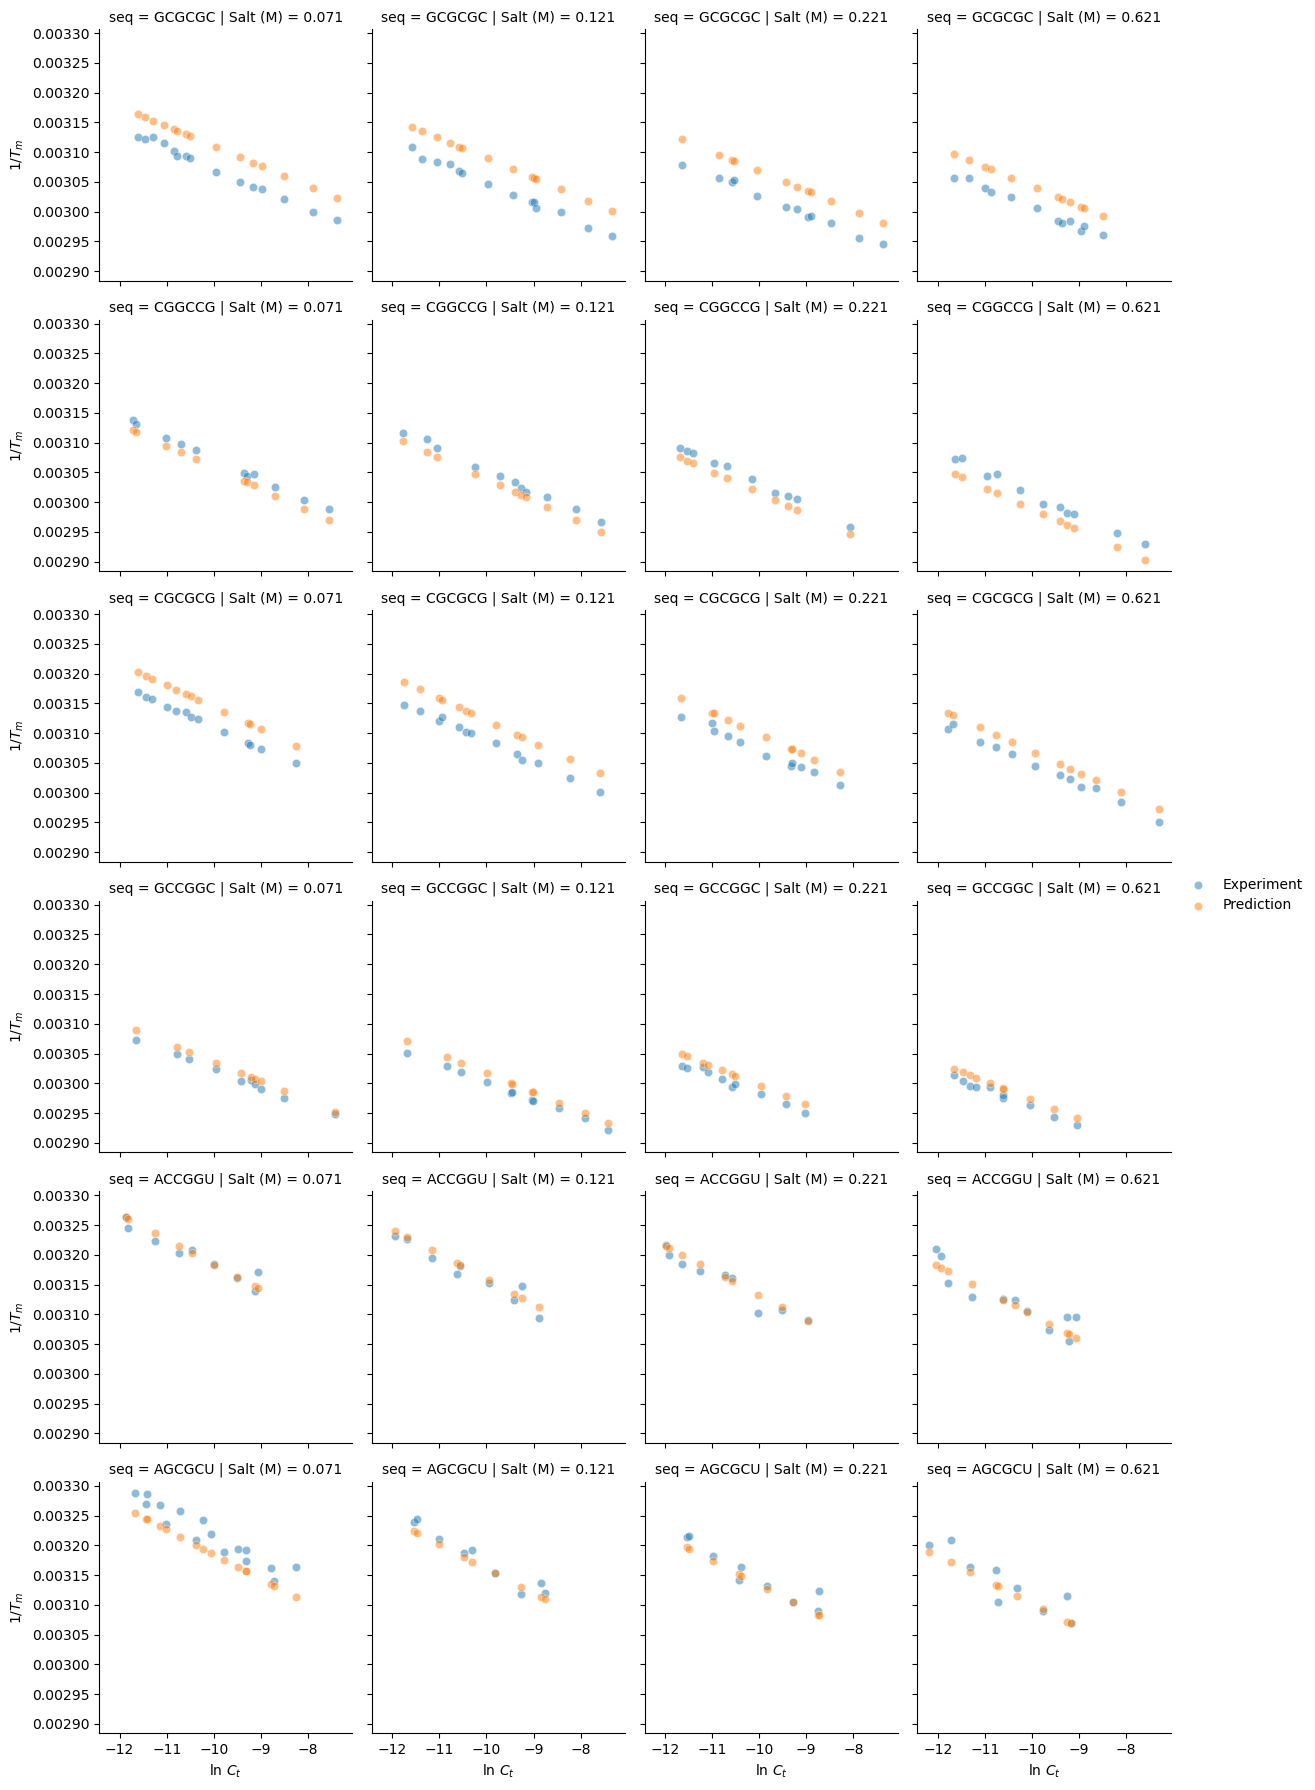

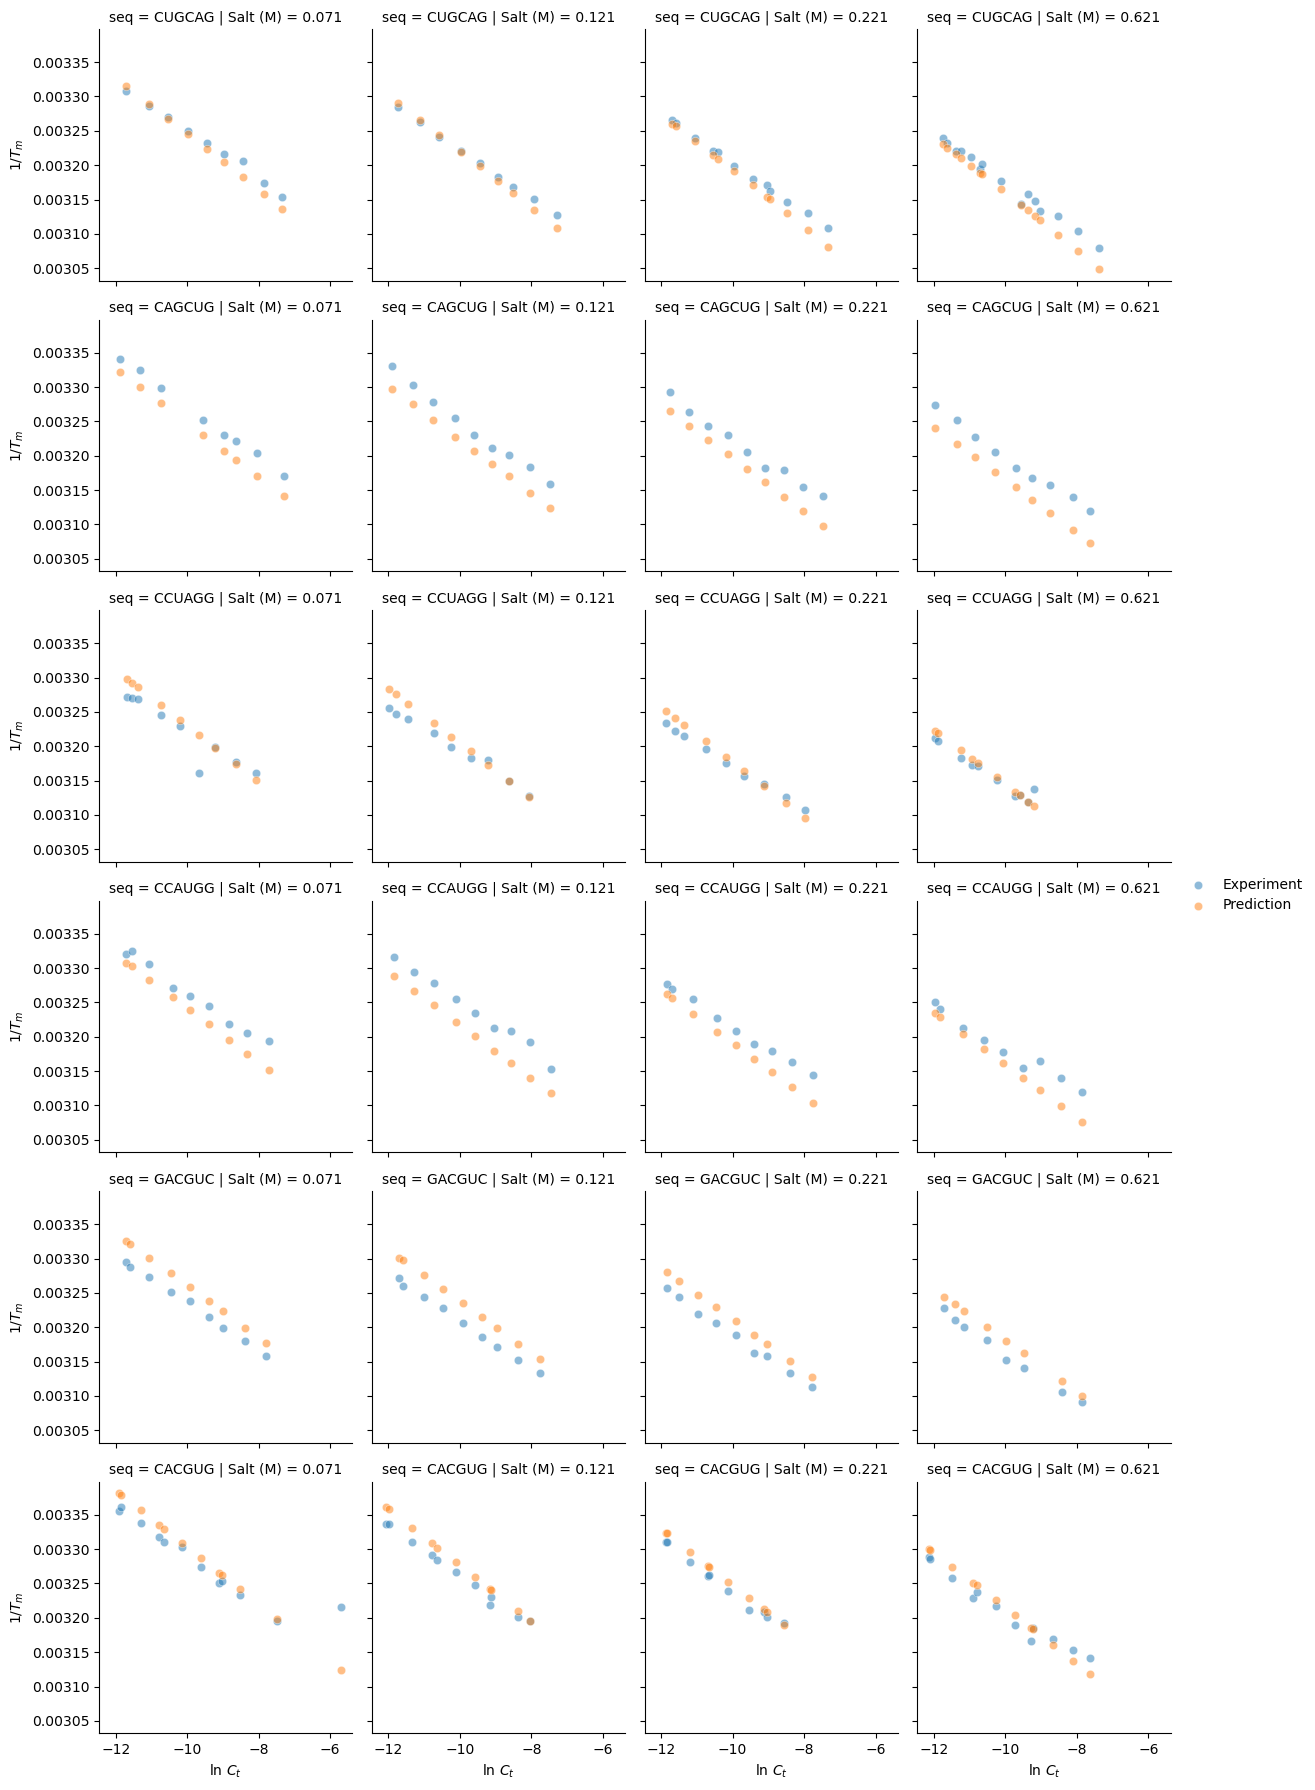

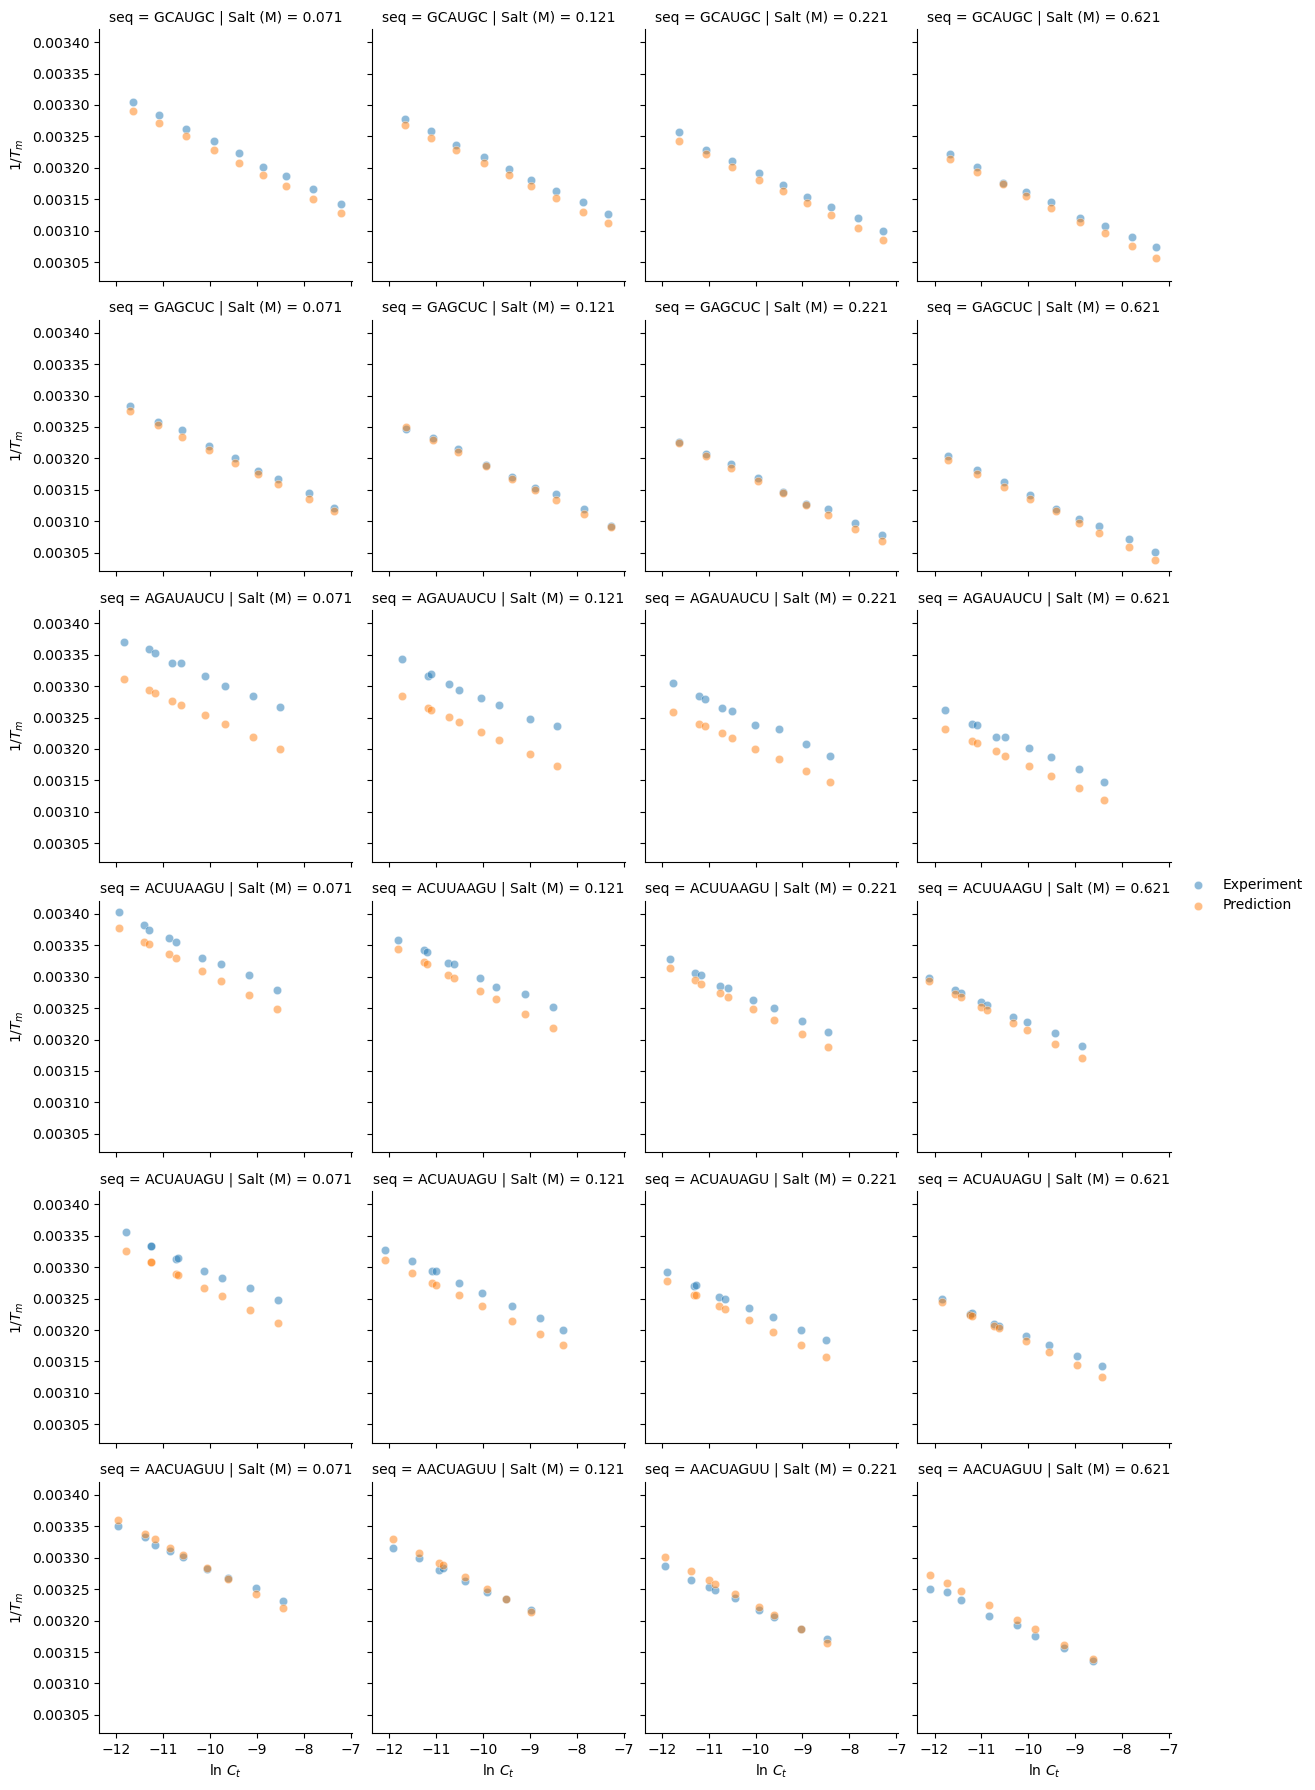

In [64]:
warnings.filterwarnings('ignore')

for i in range(3):
    df = dfTm[(dfTm['seq'].isin(duplexes[i*6:i*6+6])) & (dfTm['sodium'] != 1.021) & (dfTm['type'].isin(['exp', 'predict FEE']))]
    df.rename(columns = {'type':'Label', 'logCt': 'ln $C_t$', 'invT': '$1/T_m$', 'sodium': 'Salt (M)'}, inplace = True)

    g = sns.FacetGrid(data=df, col='Salt (M)', row='seq', hue='Label')
    g.map(sns.scatterplot, 'ln $C_t$', '$1/T_m$', alpha=0.5)

    g.add_legend(title="")
    
    new_labels = ['Experiment', 'Prediction']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    plt.savefig(FIG+'TmCtPlot_{}.pdf'.format(i), bbox_inches='tight', dpi=200)
    plt.show()

In [65]:
R = RNA.GASCONST/1000
rhoLst = [0.071, 0.121, 0.221, 0.621]
allH = []
allS = []
allH_exp = []
allS_exp = []


for w in duplexes:
    seqH = []
    seqS = []
    seqH_exp = []
    seqS_exp = []
    for label in ['exp', 'predict FEE']:
        H = []
        S = []
        for rho in rhoLst:
            df = dfTm[(dfTm['seq'] == w) & (dfTm['type'] == label) & (dfTm['sodium'] == rho)]
            y = np.array(df['invT'])
            x = np.array(df['logCt'])
            A = np.vstack([x, np.ones(len(x))]).T
            m, c = np.linalg.lstsq(A, y, rcond=None)[0]
            h = R/m
            H.append(h)
            S.append(c*h)
        if label == 'exp':
            seqH_exp.append(H)
            seqS_exp.append(S)
        else:
            seqH.append(H)
            seqS.append(S)
    allH.append(seqH)
    allS.append(seqS)
    allH_exp.append(seqH_exp)
    allS_exp.append(seqS_exp)
    

    
dfThermo = pd.DataFrame({'seq': flattenLst([[w]*4 for w in duplexes]),
                         'size': flattenLst([[len(w)-1]*4 for w in duplexes]),
                         'rho': [rho for rho in rhoLst]*(len(duplexes)),
                         'Enthalpy': flattenLst(flattenLst(allH)), 'Entropy': flattenLst(flattenLst(allS)),
                         'Enthalpy_exp': flattenLst(flattenLst(allH_exp)), 'Entropy_exp': flattenLst(flattenLst(allS_exp))})

In [66]:
dfThermo['Enthalpy_diff'] = (dfThermo['Enthalpy'] - dfThermo['Enthalpy_exp'])/dfThermo['size']
dfThermo['Entropy_diff'] = (dfThermo['Entropy'] - dfThermo['Entropy_exp'])/dfThermo['size']
dfThermo

,seq,size,rho,Enthalpy,Entropy,Enthalpy_exp,Entropy_exp,Enthalpy_diff,Entropy_diff
0,CGCGCG,5,0.071,-53.926184,-0.149643,-55.415172,-0.152479,0.297798,0.000567
1,CGCGCG,5,0.121,-54.216694,-0.149374,-55.594031,-0.151789,0.275467,0.000483
2,CGCGCG,5,0.221,-54.724366,-0.149671,-57.606816,-0.157128,0.576490,0.001491
3,CGCGCG,5,0.621,-55.082536,-0.149222,-56.623331,-0.152810,0.308159,0.000717
4,CGGCCG,5,0.071,-54.838883,-0.147871,-55.647212,-0.151163,0.161666,0.000658
...,...,...,...,...,...,...,...,...,...
67,ACUUAAGU,7,0.621,-53.175947,-0.151024,-60.406223,-0.175051,1.032897,0.003432
68,AGAUAUCU,7,0.071,-58.823162,-0.171276,-61.993586,-0.185551,0.452918,0.002039
69,AGAUAUCU,7,0.121,-59.266498,-0.171315,-62.415619,-0.184970,0.449874,0.001951
70,AGAUAUCU,7,0.221,-59.828788,-0.171613,-58.525240,-0.169951,-0.186221,-0.000237


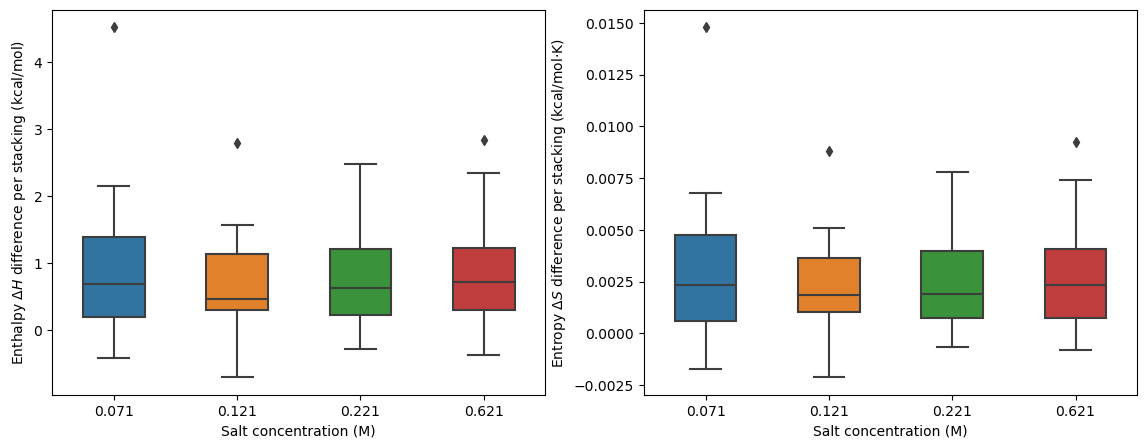

In [67]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)


sns.boxplot(data=dfThermo, x='rho', y='Enthalpy_diff', width=0.5)

plt.xlabel('Salt concentration (M)')
plt.ylabel(r'Enthalpy $\Delta H$ difference per stacking (kcal/mol)')

ax2 = plt.subplot(122)

sns.boxplot(data=dfThermo, x='rho', y='Entropy_diff', width=0.5)
plt.xlabel('Salt concentration (M)')
plt.ylabel(r'Entropy $\Delta S$ difference per stacking (kcal/mol$\cdot$K)')
plt.savefig(FIG+'/thermo_diff.pdf', bbox_inches='tight', dpi=200)

plt.show()

### Nakano _et al_, 2007

In [68]:
r14cg = 'GCAAGCCGGCUUGC'
r12cg = 'CAAGCCGGCUUG'
r10cg = 'AAGCCGGCUU'
r14ua = 'GCAAGUUAACUUGC'
r12ua = 'CAAGUUAACUUG'
r10ua = 'AAGUUAACUU'
r14cgcaag = 'GCAAGCAAGCUUGC'
r14cgccag = 'GCAAGCCAGCUUGC'
r14cgccga = 'GCAAGCCGACUUGC'
r14cgccaa = 'GCAAGCCAACUUGC'

In [69]:
def chenTmCorrection(fgc, rho1, rho2):
    return (-1.842*fgc+2.675)*log(rho2/rho1) - 0.7348*(log(rho2)*log(rho2)-log(rho1)*log(rho1))

In [70]:
label = ['r14cg', 'r12cg', 'r10cg', 'r14ua', 'r12ua', 'r10ua', 'r14cgccag', 'r14cgccga']
complement = [True, True, True, True, True, True, False, False]
Tm1M = [88.6, 85.0, 85.6, 72.3, 61.2, 55.3, 74.0, 67.2, 81.7, 74.0, 67.8, 61.5, 53.0, 46.2, 58.0, 66.3]
Tm001M = [66.5, 60.5, 63.0, 55.0, 40.6, 32.2, 54.7, 56.2, 59.3, 50.4, 50.0, 44.2, 28.2, 20.7, 47.2, 55.0]

chenTmCorr = []
vrnaTm1M = []
vrnaTm001M = []

GC = []
# Species 100 muM
for ind, seq in enumerate(label):
    GC.append(gc(locals()[seq]))
    mono = locals()[seq]
    chenTmCorr.append(chenTmCorrection(gc(locals()[seq]), 1.000, 0.010))
    vrnaTm1M.append(get_Tm(locals()[seq], 1.0002, 100*1e-6))
    vrnaTm001M.append(get_Tm(locals()[seq], 0.0102, 100*1e-6))
# Species 2muM
for ind, seq in enumerate(label):
    GC.append(gc(locals()[seq]))
    mono = locals()[seq]
    chenTmCorr.append(chenTmCorrection(gc(locals()[seq]), 1.0002, 0.0102))
    vrnaTm1M.append(get_Tm(locals()[seq], 1.0002, 2*1e-6))
    vrnaTm001M.append(get_Tm(locals()[seq], 0.0102, 2*1e-6))


NakanoTmDf = pd.DataFrame({'label': label+label, 'species': [100]*len(label)+[2]*len(label), 'GC':GC, 'Tm1M': Tm1M, 'Tm001M': Tm001M, 
                           'vrnaTm1M': vrnaTm1M, 'vrnaTm001M': vrnaTm001M,
                           'chenTmCorr': chenTmCorr, 'complementary': complement+complement})

NakanoTmDf['ExpCorr'] = NakanoTmDf.Tm001M - NakanoTmDf.Tm1M
NakanoTmDf['vrnaCorr'] = NakanoTmDf.vrnaTm001M - NakanoTmDf.vrnaTm1M
NakanoTmDf

,label,species,GC,Tm1M,Tm001M,vrnaTm1M,vrnaTm001M,chenTmCorr,complementary,ExpCorr,vrnaCorr
0,r14cg,100,0.714286,88.6,66.5,93.89649,77.49024,-21.843081,True,-22.1,-16.40625
1,r12cg,100,0.666667,85.0,60.5,87.64649,69.48242,-22.247020,True,-24.5,-18.16407
2,r10cg,100,0.600000,85.6,63.0,83.54492,64.40429,-22.812535,True,-22.6,-19.14063
3,r14ua,100,0.428571,72.3,55.0,76.56250,58.74024,-24.266716,True,-17.3,-17.82226
4,r12ua,100,0.333333,61.2,40.6,64.16016,43.79883,-25.074595,True,-20.6,-20.36133
5,r10ua,100,0.200000,55.3,32.2,52.09960,28.56445,-26.205624,True,-23.1,-23.53515
6,r14cgccag,100,0.642857,74.0,54.7,70.65429,51.80663,-22.448990,False,-19.3,-18.84766
7,r14cgccga,100,0.642857,67.2,56.2,39.40429,13.91602,-22.448990,False,-11.0,-25.48827
8,r14cg,2,0.714286,81.7,59.3,86.18164,70.55664,-21.682704,True,-22.4,-15.62500
9,r12cg,2,0.666667,74.0,50.4,78.07617,61.08398,-22.084924,True,-23.6,-16.99219


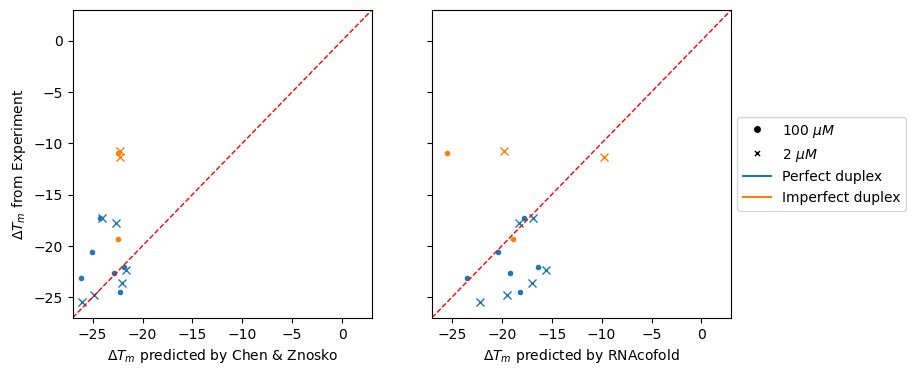

In [71]:
plt.figure(figsize=(8.5,4))
ax1 = plt.subplot(121)
plt.plot(NakanoTmDf.chenTmCorr[(NakanoTmDf.species==100) & (NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==100) & (NakanoTmDf.complementary)], '.', label=100, c=colors[0])
plt.plot(NakanoTmDf.chenTmCorr[(NakanoTmDf.species==100) & (~NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==100) & (~NakanoTmDf.complementary)], '.', label=100, c=colors[1])
plt.plot(NakanoTmDf.chenTmCorr[(NakanoTmDf.species==2) & (NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==2) & (NakanoTmDf.complementary)], 'x', label=2, c=colors[0])
plt.plot(NakanoTmDf.chenTmCorr[(NakanoTmDf.species==2) & (~NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==2) & (~NakanoTmDf.complementary)], 'x', label=2, c=colors[1])

# plt.plot(NakanoTmDf.chenTmCorr[NakanoTmDf.species==2], NakanoTmDf.ExpCorr[NakanoTmDf.species==2], 'x', label=2, c=colors[0])
plt.ylabel(r'$\Delta T_m$ from Experiment')
plt.xlabel(r'$\Delta T_m$ predicted by Chen & Znosko')
plt.xlim(-27, 3)
plt.ylim(-27, 3)
ax1.axline((1,1), slope=1, c='r', ls='--', lw=1)
ax2 = plt.subplot(122, sharey=ax1)
plt.plot(NakanoTmDf.vrnaCorr[(NakanoTmDf.species==100) & (NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==100) & (NakanoTmDf.complementary)], '.', label=100, c=colors[0])
plt.plot(NakanoTmDf.vrnaCorr[(NakanoTmDf.species==100) & (~NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==100) & (~NakanoTmDf.complementary)], '.', label=100, c=colors[1])
plt.plot(NakanoTmDf.vrnaCorr[(NakanoTmDf.species==2) & (NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==2) & (NakanoTmDf.complementary)], 'x', label=2, c=colors[0])
plt.plot(NakanoTmDf.vrnaCorr[(NakanoTmDf.species==2) & (~NakanoTmDf.complementary)], NakanoTmDf.ExpCorr[(NakanoTmDf.species==2) & (~NakanoTmDf.complementary)], 'x', label=2, c=colors[1])


# plt.plot(NakanoTmDf.vrnaCorr[NakanoTmDf.species==100], NakanoTmDf.ExpCorr[NakanoTmDf.species==100], '.', label=100, c=colors[0])
# plt.plot(NakanoTmDf.vrnaCorr[NakanoTmDf.species==2], NakanoTmDf.ExpCorr[NakanoTmDf.species==2], 'x', label=2, c=colors[0])
plt.tick_params('y', labelleft=False)
plt.xlabel('$\Delta T_m$ predicted by RNAcofold')
plt.xlim(-27, 3)
ax2.axline((1,1), slope=1, c='r', ls='--', lw=1)
legend_elements = [Line2D([], [], marker='o', color='w', markerfacecolor='black', label=r'100 $\mu M$'),
                   Line2D([], [], marker='X', color='w', markerfacecolor='black', label=r'2 $\mu M$'),
                   Line2D([], [], color=colors[0], label=r'Perfect duplex'),
                   Line2D([], [], color=colors[1], label=r'Imperfect duplex'),]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.savefig(FIG+'tmcorr.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [72]:
def rmsd(c1, c2):
    return np.sqrt(((c1 - c2)** 2).mean())

print('Chen:', rmsd(NakanoTmDf.chenTmCorr, NakanoTmDf.ExpCorr))
print('RNAcofold:', rmsd(NakanoTmDf.vrnaCorr, NakanoTmDf.ExpCorr))

Chen: 5.861918061580845
RNAcofold: 5.638313914750468


# DNA data

In [73]:
RNA.params_load_DNA_Mathews2004()

1

## Melting Temp

In [74]:
R = RNA.GASCONST / 1000

def tm(FAA, FA, FB, ct, selfComp=True):
    if selfComp:
        return (-FAA+FA+FB)/(-R*log(ct))
    else:
        return (-FAA+FA+FB)/(R*log(4)-R*log(ct))

def invSeq(seq):
    return ''.join([{'A':'T', 'C':'G', 'G':'C', 'T':'A'}[c] for c in seq[::-1]])
        
    

def duplex_sym_Tm(w, rho, ct, T, init=99999):
    md = RNA.md(salt=rho, temperature=T, saltDPXInit=init)
    md.uniq_ML = 1
    fc = RNA.fold_compound('{}&{}'.format(w, invSeq(w)), md)
    _, FA, FB, FcAB, FAB = fc.pf_dimer()
    return tm(FcAB, FA, FB, ct, w==invSeq(w))

def get_Tm(w, rho, ct, init=99999):
    curlower = 0
    curupper = 100
    current_T = 0
    expTm = 0
    while (not abs(curupper-curlower) < 0.05):
        current_T = round((curlower+curupper)/2, 5)
        expTm = round(duplex_sym_Tm(w, rho, ct, current_T, init=init)-RNA.K0, 5)

        if abs(current_T-expTm) < 0.05:
            break
               
        if current_T > expTm:
            curupper = current_T
        else:
            curlower = current_T           
    return current_T

duplexe_dna_init = lambda c, rho: round(c*np.log(rho/1.021))


In [75]:
def compute_tm_error(k, DNA_seqs, rho_list, dna_exp_tm):
    exp_tm_diff = []
    vrna_tm_diff = []

    for ind, w in enumerate(DNA_seqs):
        tm_lst = dna_exp_tm[ind]
        for rho, t in zip(rho_list, tm_lst[:-1]):
            tm_diff_exp = t - tm_lst[-1]
            tm_1M = get_Tm(w, 1.02, 2*1e-6, duplexe_dna_init(k,1.02))
            tm_rho = get_Tm(w, rho, 2*1e-6, duplexe_dna_init(k,rho))

            exp_tm_diff.append(tm_diff_exp)
            vrna_tm_diff.append(tm_rho-tm_1M)
    diff = np.array(vrna_tm_diff) - np.array(exp_tm_diff)
    return np.sqrt((diff**2).mean()), diff.mean()

In [76]:
def compute_dna_tm(lower, upper):
    # Prepare train set
    DNA_seqs_train = []
    rho_list = [0.069, 0.119, 0.220, 0.621]
    dna_exp_tm_train = []

    with open('Data/Owczarzy_DNA/dna_duplex_tm.csv') as f:
        for line in f.readlines():
            lst = line.strip().split(',')
            seq = lst[0]
            if (len(seq) > upper) or (len(seq) < lower):
                continue
            DNA_seqs_train.append(lst[0])
            dna_exp_tm_train.append(list(map(float, lst[1:])))
    dna_exp_tm_train = np.array(dna_exp_tm_train)
    
    # Compute dna initialization correction coefficient
    curlower = -100
    curupper = 0
    k = -50
    while (not abs(curupper-curlower) < 0.005):
        k = round((curlower+curupper)/2, 3)
#         print(k)
        err = compute_tm_error(k, DNA_seqs_train, rho_list, dna_exp_tm_train)

        if err[1] > 0:
            curupper = k
        else:
            curlower = k

    dna_coeff = k
    print("Coefficient:", dna_coeff)
    
    # Test
    dna_duplexes_test = []
    exp_tm_diff_test = []
    vrna_tm_diff_test = []


    with open('Data/Owczarzy_DNA/dna_duplexes_tm_test.csv') as f:
        for line in f.readlines():
            lst = line.strip().split(',')
            seq = lst[0]
            if (len(seq) > upper) or (len(seq) < lower):
                continue
            ct = float(lst[1])
            rho1 = float(lst[2])/1000
            rho2 = float(lst[4])/1000
            tm_diff_exp = float(lst[5]) - float(lst[3])
            tm_1 = get_Tm(seq, rho1, ct*1e-6, duplexe_dna_init(dna_coeff,rho1))
            tm_2 = get_Tm(seq, rho2, ct*1e-6, duplexe_dna_init(dna_coeff,rho2))

            dna_duplexes_test.append(w)
            exp_tm_diff_test.append(tm_diff_exp)
            vrna_tm_diff_test.append(tm_2-tm_1)

    DNATmDf = pd.DataFrame({'seq': dna_duplexes_test, 'expTmCorr': exp_tm_diff_test, 'vrnaTmCorr': vrna_tm_diff_test})

    plt.figure(figsize=(4,4))
    plt.plot(DNATmDf['vrnaTmCorr'], DNATmDf['expTmCorr'], '.', label=100, c=colors[0])

    plt.ylabel(r'$\Delta T_m$ from Experiment')
    plt.xlabel(r'Predicted $\Delta T_m$')
    plt.xlim(-14, 1)
    plt.ylim(-14, 1)
    plt.axline((1,1), slope=1, c='r', ls='--', lw=1)
#     plt.title("DNA length Lower bound: {} Upper bound: {}".format(lower, upper))
    plt.savefig(FIG+'dna_tmcorr.pdf', bbox_inches='tight', dpi=200)
    plt.show()

Coefficient: -58.389


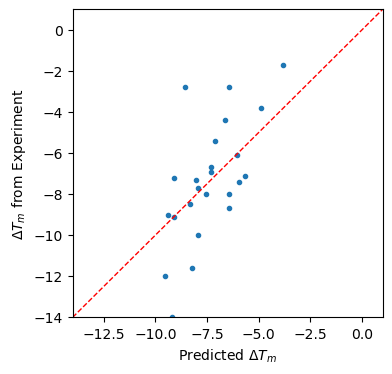

In [77]:
compute_dna_tm(1, 11)